# Example of discrete hedging experiment for a European Call option under the BS model
Consider a market model with two assets, a Bank account and a Stock with $P$-dynamics

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS(t) = \mu S(t) dt + \sigma S(t) dW(t), \hspace{10mm} S(0) = s > 0
$$

Consider the European call options that at time $T$ pays $X = (S(T) - K)^+$ where $K > 0$ is the strike price.

Chope the time interval between now (time 0) and expiry of the call-option (time $T$) into $N$ pieces; denote the discretization points $t_i$.  

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print('Adding module')
    sys.path.append(module_path)

Adding module


In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jaxfin.models.gbm import UnivGeometricBrownianMotion
from jaxfin.price_engine.black_scholes import european_price, delta_european

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
s0 = 100
sigma = 0.2
mean = 0.00

params = {
    's0' : s0,
    'dtype' : jnp.float32,
    'mean' : mean,
    'sigma': sigma
}
gmb = UnivGeometricBrownianMotion(**params)

In [5]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 1000

stock_paths = gmb.simulate_paths(seed, maturity, N, n_sim)

$$
K = 100 \\
r = 0.0 \\
$$

In [6]:
K = 110
discount_rate = 0.0

In [7]:
n_rebalancing = jnp.asarray(jnp.linspace(10, 300, 10), jnp.int32)
hedging_errors = []
mean_hedging_errors = []
normalized_std_hedge_errors = []

In [9]:
initial_outlay = european_price(stock_paths[0, 0], K, maturity, sigma, discount_rate)

for N in n_rebalancing:

    stock_paths = gmb.simulate_paths(seed, maturity, N, n_sim)
    dt = maturity / N
    
    deltas = [delta_european(stock_paths[i], K, maturity - i * dt, sigma, discount_rate, dtype=jnp.float32) for i in range(0, N)]
    cs = [european_price(stock_paths[i], K, maturity - i * dt, sigma, discount_rate, dtype=jnp.float32) for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0]]
    vs = [cs[0]]
    
    for i in range(1, N):
        vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
        b.append(vs[i] - deltas[i] * stock_paths[i])
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)
    
    mean_hedging_errors.append(jnp.mean(hedge_error[-1]))
    normalized_std_hedge_errors.append(jnp.divide(jnp.std(hedge_error[-1]), initial_outlay))    

In [13]:
jnp.asarray(normalized_std_hedge_errors)

Array([0.50924355, 0.24411018, 0.18256776, 0.1551551 , 0.1360827 ,
       0.1288601 , 0.11645123, 0.10806318, 0.10620437, 0.08788706],      dtype=float32)

In [41]:
m, b = jnp.polyfit(x=jnp.log(jnp.astype(n_rebalancing, jnp.float32)), y=jnp.log(jnp.asarray(normalized_std_hedge_errors)), deg=1)
print(f'$y = {m}x {b:+}$')

$y = -0.4903881549835205x +0.43752771615982056$


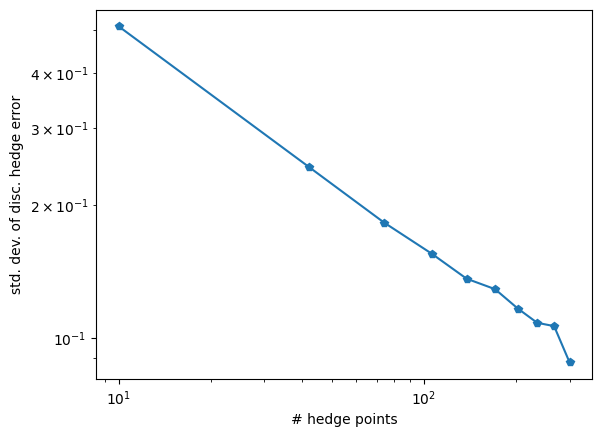

In [43]:
plt.loglog(n_rebalancing, jnp.asarray(normalized_std_hedge_errors), '-p')

plt.ylabel("std. dev. of disc. hedge error")
plt.xlabel("# hedge points")
plt.show()